In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import dataloader
import preprocessing
import data_augmentation
import add_features

import os,sys,inspect
import raw_dataloader

# Analyze correlation between ERSP and solution latency

In [64]:
data_cate = 2
num_channels = 21
corr_all = np.zeros((12,num_channels,57))    # Including each subject (0-10) and all (11)
sub_IDs = list(range(11))+[100]
num_examples_all = np.zeros(12)

for i, sub_ID in enumerate(sub_IDs):
    if data_cate == 1:
        ERSP_all, tmp_all, freqs = dataloader.load_data()
    else:
        with open('./raw_data/ERSP_from_raw_%d_channel%d.data'%(sub_ID, num_channels), 'rb') as fp:
            dict_ERSP = pickle.load(fp)
        ERSP_all, tmp_all, freqs = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq']

    ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 60)
    ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all, threshold=0.0)

    # Change the dimension of ERSP_all
    ERSP_corr = ERSP_all.reshape((ERSP_all.shape[0],-1)).T
    print('Shape of ERSP_corr:', ERSP_corr.shape)

    # Make SLs the same shape as ERSP_all
    SLs_corr = np.tile(SLs, (ERSP_corr.shape[0], 1))
    print('Shape of SLs_corr: ', SLs_corr.shape)

    # Calculate correlation matrix between ERSP and SLs
    corr_mat = np.corrcoef(ERSP_corr, SLs_corr)
    corr_ERSP_SLs = corr_mat[:ERSP_corr.shape[0], ERSP_corr.shape[0]].reshape((num_channels,-1))
    corr_all[i,:] = corr_ERSP_SLs
    num_examples_all[i] = len(ERSP_all)
    print(corr_ERSP_SLs.shape)

    # Plot 
    channels = pd.read_csv('./Channel_coordinate/Channel_location_angle_21.csv')['Channel']
    num_col = int(num_channels/3)
    fig, axs = plt.subplots(3, num_col, figsize=(10, 4))
    for i_fig in range(num_channels):

        row_fig = i_fig//num_col
        col_fig = i_fig%num_col

        axs[row_fig, col_fig].plot(freqs, corr_ERSP_SLs[i_fig, :])
        axs[row_fig, col_fig].set_title(channels[i_fig])

    fig.tight_layout(pad=1.0)
    '''
    fig.suptitle('Correlation between ERSP and solution latency')
    fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')
    fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')
    '''
    fig.savefig('./results/Analysis/data%d_sub%d_channel%d_corr_ERSP_SL.png'%(data_cate,sub_ID,num_channels))
    plt.close()
    
# Calculate different between each subject and all subjects
diff_sub_all = np.zeros((11,num_channels))

for i in range(num_channels):
    diff_sub_all[:,i] = np.sum(np.abs(corr_all[:-1,i,:]-corr_all[-1,i,:]), axis=1)

> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 59)
Shape of SLs_corr:  (1197, 59)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 70)
Shape of SLs_corr:  (1197, 70)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 174)
Shape of SLs_corr:  (1197, 174)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 137)
Shape of SLs_corr:  (1197, 137)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 43)
Shape of SLs_corr:  (1197, 43)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 94)
Shape of SLs_corr:  (1197, 94)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 112)
Shape of SLs_corr:  (1197, 112)
(21, 57)
> Remove 0 trials (60.000 sec)
Base threshold: 0.000000
Shape of ERSP_corr: (1197, 60)
Shape of SLs_corr:

In [80]:
np.mean(diff_sub_all/57, axis=1)

array([0.11069669, 0.0959503 , 0.08319538, 0.11347259, 0.15945498,
       0.12145526, 0.10378463, 0.11290951, 0.09941063, 0.13517146,
       0.1204774 ])

In [77]:
np.sum(diff_sub_all, axis=0)

array([56.37629036, 54.82221134, 54.60541357, 75.30401744, 67.09400508,
       65.75308259, 68.62377444, 56.30353271, 68.65321259, 64.41526902,
       73.76872512, 63.18703888, 73.77250303, 62.46780155, 80.03782754,
       71.77670752, 80.25589337, 87.25707373, 99.31848441, 83.79446174,
       95.81933216])

In [72]:
np.corrcoef(np.min(diff_sub_all, axis=1), num_examples_all[:-1])
'''
Minimum of difference between correlation of ERSP and SLs for each subject and all subjects 
is negatively correlated with number of examples for each subjects
'''

array([[ 1.        , -0.82735224],
       [-0.82735224,  1.        ]])

In [76]:
np.corrcoef(np.sum(diff_sub_all, axis=1), num_examples_all[:-1])

array([[ 1.        , -0.68331696],
       [-0.68331696,  1.        ]])

## Select ERSP with correlation larger than certain quantile

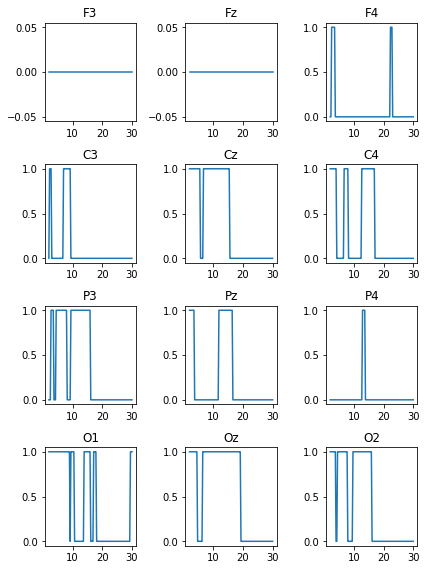

In [14]:
abs_corr = abs(corr_ERSP_SLs)

select_indices = np.zeros(abs_corr.shape)
select_indices[abs_corr >= np.quantile(abs_corr, 0.75)] = 1

fig, axs = plt.subplots(4, 3, figsize=(6, 8))
for i_fig in range(12):
    
    row_fig = i_fig//3
    col_fig = i_fig%3
    
    axs[row_fig, col_fig].plot(freqs, select_indices[i_fig,:])
    axs[row_fig, col_fig].set_title(channels[i_fig])
    
fig.tight_layout(pad=1.0)

# Analyze data distribution after data augmentation

In [2]:
X, _, Y, _ = raw_dataloader.read_data([1,2,3], range(11), pred_type='class')
X = X.reshape((X.shape[0],-1))
#plt.hist(Y, bins=10)
hist, bin_edges = np.histogram(Y, bins=10)

After removing outliers, X shape:  (1084, 12, 512)
Arrange all the channels as the same order

Mean of all trials: 13.218015


--- Data Augmentation (SMOTER) ---
Part 1: 156
Part 2: 59
Part 3: 39
Part 4: 21
Part 5: 14
Part 6: 14
Part 7: 10
Part 8: 6
Part 9: 1
> After SMOTER
Mean of all trials: 47.358363
Data: (1084, 6144) -> (6185, 6144)
Target: (1084,) -> (6185,)


(array([764., 780., 767., 780., 777., 770., 770., 770.,   6.,   1.]),
 array([  0.15234375,  12.07578125,  23.99921875,  35.92265625,
         47.84609375,  59.76953125,  71.69296875,  83.61640625,
         95.53984375, 107.46328125, 119.38671875]),
 <a list of 10 Patch objects>)

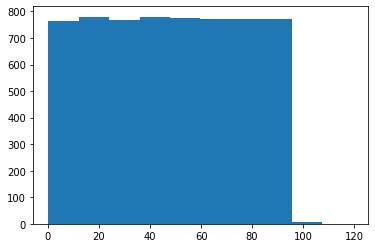

In [3]:
X_aug, Y_aug = data_augmentation.aug(X,Y,'SMOTER')
plt.hist(Y_aug, bins=10)

# Analyze correlation between channels

In [2]:
data_cate = 1

if data_cate == 1:
    ERSP_all, tmp_all, freqs = dataloader.load_data()
else:
    with open('./ERSP_from_raw.data', 'rb') as fp:
        dict_ERSP = pickle.load(fp)
    ERSP_all, tmp_all, freqs = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq']

ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 60)
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all, threshold=0.0)

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)
> Remove 9 trials (60.000 sec)
Base threshold: 0.000000


In [3]:
corr = add_features.get_correlations(ERSP_all)
for i in range(corr.shape[1]):
    print('%d. (%.3f,%.3f)'%(i, np.mean(corr[:,i]), np.std(corr[:,i])))

# Analyze bandpower vs solution latency

In [2]:
data_cate = 1

if data_cate == 1:
    ERSP_all, tmp_all, freqs = dataloader.load_data()
else:
    with open('./ERSP_from_raw.data', 'rb') as fp:
        dict_ERSP = pickle.load(fp)
    ERSP_all, tmp_all, freqs = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq']

ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 60)
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all, threshold=0.0)

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)
> Remove 9 trials (60.000 sec)
Base threshold: 0.000000


In [3]:
lower, higher = [4, 8, 14], [8, 14, 30]
bandpower = preprocessing.bandpower(ERSP_all, freqs, lower, higher)

# Sort SLs
sorted_indices = np.argsort(SLs)
bandpower = bandpower[sorted_indices, :]
SLs = SLs[sorted_indices]

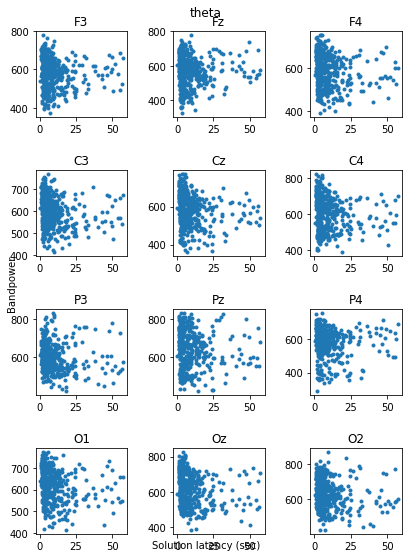

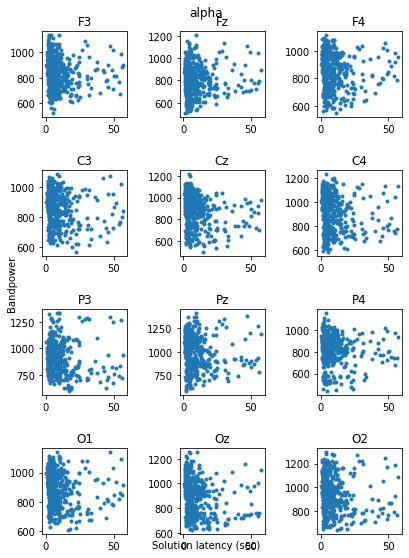

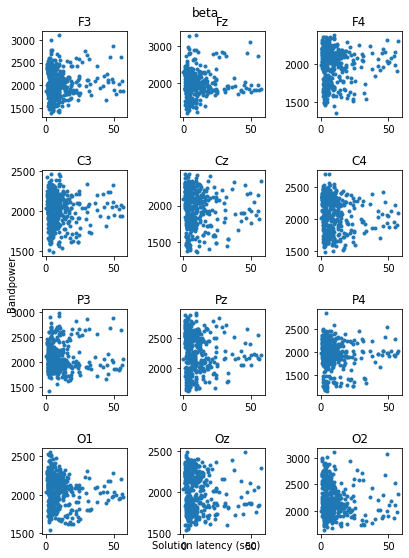

In [7]:
# Plot
channels = pd.read_csv('Channel_location.csv')['Channel']
for i_band, band in enumerate(['theta', 'alpha', 'beta']):
    fig, axs = plt.subplots(4, 3, figsize=(6, 8))
    for i_fig in range(12):

        row_fig = i_fig//3
        col_fig = i_fig%3

        axs[row_fig, col_fig].scatter(SLs, bandpower[:,i_fig,i_band], marker='.')
        axs[row_fig, col_fig].set_title(channels[i_fig])

    fig.tight_layout(pad=2.0)
    fig.suptitle(band)
    fig.text(0.5, 0.04, 'Solution latency (sec)', ha='center')
    fig.text(0.04, 0.5, 'Bandpower', va='center', rotation='vertical')
    plt.savefig('%s_corr.png'%(band))

# Analyze relation between mean and standard error of prediction for each subject

In [11]:
# Read results for each subject
num_subject = 11
std_all = [0]*num_subject
mape_all = [0]*num_subject
mean_target_all = [0]*num_subject
num_target_all = [0]*num_subject

for i_sub in range(11):
    
    folder = 'eegnet_trans_power_data2_None_L2_sub%d'%(i_sub)
    for i in range(10):
        with open('./results/%s/%s_split0_exp%d.data'%(folder, folder, i), 'rb') as fp:
            dict_error = pickle.load(fp)
        target, pred = dict_error['target'], dict_error['pred'],
        std, mape = dict_error['test_std'][-1], dict_error['test_MAPE'][-1]
        std_all[i_sub] += std
        mape_all[i_sub] += mape
        mean_target_all[i_sub] += np.sum(target)
        num_target_all[i_sub] += len(target)

    std_all[i_sub] /= 10
    mape_all[i_sub] /= 10
    mean_target_all[i_sub] /= num_target_all[i_sub]


In [13]:
mean_target_all = np.array(mean_target_all)
std_all = np.array(std_all)
print(np.corrcoef(mean_target_all, std_all))

[[1.         0.88297584]
 [0.88297584 1.        ]]


In [14]:
std_all

array([15.49975371, 12.79526043,  5.41404067,  9.13512869, 13.74014063,
       12.2137207 ,  8.46496837, 13.82000465, 10.87478518, 12.31747799,
       15.67033329])

In [15]:
mean_target_all

array([14.76019597, 12.13080357,  4.75305316,  6.99657847, 19.7115734 ,
       10.58007812,  7.85341099, 14.21966146,  9.33847403, 14.46393694,
       16.86206055])

# Analyze conditional entropy of signal between channels and solution latency

In [13]:
# Load conditional entropy
with open('./raw_data/CE_sub100', 'rb') as fp:
    CE = pickle.load(fp)
print(CE.shape)

# PCA
pca = PCA(n_components=10)
pca.fit(CE)
CE = pca.transform(CE)
    
# Load raw data
X, _, Y_reg, channels = raw_dataloader.read_data([1,2,3], date=range(11), pred_type='class', rm_baseline=True)
X, Y_reg = preprocessing.remove_trials(X, Y_reg, 60)

# Change the dimension of CE
CE_corr = CE.T
print('Shape of CE_corr:', CE_corr.shape)

# Make SLs the same shape as ERSP_all
SLs_corr = np.tile(Y_reg, (CE_corr.shape[0], 1))
print('Shape of SLs_corr: ', SLs_corr.shape)

(1039, 132)
After removing outliers, X shape:  (1084, 12, 512)
Arrange all the channels as the same order

Mean of all trials: 13.218015
> Remove 45 trials (60.000 sec)
Shape of CE_corr: (10, 1039)
Shape of SLs_corr:  (10, 1039)


In [14]:
num_features = CE_corr.shape[0]
corr_CE_SLs = np.corrcoef(CE_corr, SLs_corr)
print(np.diag(corr_CE_SLs[num_features:, :num_features]))

[ 0.13626574  0.16560457 -0.02905524  0.10446795 -0.01160042  0.13034872
  0.07773963  0.09438066 -0.11654646  0.05383372]
